In [1]:
RUN_CONFIG = {
    "EPOCHS": 10,          
    "BATCH_SIZE": 32,
    "IMG_SIZE": 224,
    "LR": 3e-4,
    "WEIGHT_DECAY": 1e-4,
    "NUM_WORKERS": 2,
    "SEED": 42,
    "SAVE_PATH": "/kaggle/working/best_xception_foodvitx.pth"
}

In [2]:
import os, re, random, time
from collections import defaultdict
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from tqdm import tqdm

random.seed(RUN_CONFIG["SEED"])
np.random.seed(RUN_CONFIG["SEED"])
torch.manual_seed(RUN_CONFIG["SEED"])
torch.cuda.manual_seed_all(RUN_CONFIG["SEED"])

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
FOOD101_ROOT = "/kaggle/input/food-101/food-101/food-101/images"
FOOD101_META = "/kaggle/input/food-101/food-101/food-101/meta"

VALID_EXTENSIONS = (".jpg", ".jpeg", ".png")

assert os.path.exists(FOOD101_ROOT), "FOOD101_ROOT path is wrong"
assert os.path.exists(FOOD101_META), "FOOD101_META path is wrong"

print("FOOD101_ROOT OK")
print("FOOD101_META OK")

FOOD101_ROOT OK
FOOD101_META OK


In [4]:
food101_classes = sorted([
    d for d in os.listdir(FOOD101_ROOT)
    if os.path.isdir(os.path.join(FOOD101_ROOT, d))
])

label_to_id = {cls: i for i, cls in enumerate(food101_classes)}
NUM_CLASSES = len(label_to_id)

print("Number of classes:", NUM_CLASSES)

Number of classes: 101


In [5]:
def read_split(file):
    with open(os.path.join(FOOD101_META, file)) as f:
        return set(line.strip() for line in f)

train_ids = read_split("train.txt")
test_ids  = read_split("test.txt")

In [6]:
food_train, food_test = [], []

for cls in food101_classes:
    label = label_to_id[cls]
    folder = os.path.join(FOOD101_ROOT, cls)

    for fname in os.listdir(folder):
        if not fname.lower().endswith(VALID_EXTENSIONS):
            continue

        img_id = fname.rsplit(".", 1)[0]
        rel = f"{cls}/{img_id}"
        full = os.path.join(folder, fname)

        if rel in train_ids:
            food_train.append((full, label))
        elif rel in test_ids:
            food_test.append((full, label))

print("Train samples:", len(food_train))
print("Test samples :", len(food_test))

Train samples: 75750
Test samples : 25250


In [7]:
def stratified_split(samples, ratio=0.8):
    by_class = defaultdict(list)
    for s in samples:
        by_class[s[1]].append(s)

    train, val = [], []
    for items in by_class.values():
        random.shuffle(items)
        k = int(len(items) * ratio)
        train += items[:k]
        val   += items[k:]
    return train, val

train_samples, val_samples = stratified_split(food_train)
test_samples = food_test

In [8]:
class FoodDataset(Dataset):
    def __init__(self, samples, transform):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            img = Image.open(path).convert("RGB")
        except:
            return self.__getitem__((idx + 1) % len(self.samples))
        return self.transform(img), label

In [9]:
IMG_SIZE = RUN_CONFIG["IMG_SIZE"]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1,0.1,0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_loader = DataLoader(FoodDataset(train_samples, train_tfms),
                          batch_size=RUN_CONFIG["BATCH_SIZE"],
                          shuffle=True, num_workers=RUN_CONFIG["NUM_WORKERS"])

val_loader = DataLoader(FoodDataset(val_samples, test_tfms),
                        batch_size=RUN_CONFIG["BATCH_SIZE"],
                        shuffle=False, num_workers=RUN_CONFIG["NUM_WORKERS"])

test_loader = DataLoader(FoodDataset(test_samples, test_tfms),
                         batch_size=RUN_CONFIG["BATCH_SIZE"],
                         shuffle=False, num_workers=RUN_CONFIG["NUM_WORKERS"])

In [10]:
class FoodViTX(nn.Module):
    def __init__(self, proj_dim=256, layers=2, heads=4):
        super().__init__()

        self.backbone = timm.create_model(
            "xception",
            pretrained=True,
            features_only=True
        )

        in_ch = self.backbone.feature_info[-1]["num_chs"]
        self.proj = nn.Conv2d(in_ch, proj_dim, 1)

        encoder = nn.TransformerEncoderLayer(
            d_model=proj_dim,
            nhead=heads,
            dim_feedforward=1024,
            activation="gelu",
            dropout=0.1
        )

        self.transformer = nn.TransformerEncoder(encoder, layers)
        self.head = nn.Linear(proj_dim, NUM_CLASSES)

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = self.proj(x)
        x = x.flatten(2).permute(2,0,1)
        x = self.transformer(x).mean(0)
        return self.head(x)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FoodViTX().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=RUN_CONFIG["LR"],
    weight_decay=RUN_CONFIG["WEIGHT_DECAY"]
)

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [12]:
@torch.no_grad()
def topk_accuracy(outputs, targets, k):
    _, preds = outputs.topk(k, 1, True, True)
    correct = preds.eq(targets.view(-1,1))
    return correct.any(dim=1).float().mean().item()


@torch.no_grad()
def macro_f1(outputs, targets):
    preds = outputs.argmax(1).cpu().numpy()
    targets = targets.cpu().numpy()
    f1s = []

    for c in range(NUM_CLASSES):
        tp = ((preds==c)&(targets==c)).sum()
        fp = ((preds==c)&(targets!=c)).sum()
        fn = ((preds!=c)&(targets==c)).sum()

        p = tp/(tp+fp) if (tp+fp)>0 else 0
        r = tp/(tp+fn) if (tp+fn)>0 else 0
        f1 = 2*p*r/(p+r) if (p+r)>0 else 0
        f1s.append(f1)

    return float(np.mean(f1s))

In [13]:
def train_one_epoch():
    model.train()
    total, correct, loss_sum = 0, 0, 0

    for x,y in tqdm(train_loader):
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()*y.size(0)
        correct += (out.argmax(1)==y).sum().item()
        total += y.size(0)

    return loss_sum/total, correct/total

In [14]:
@torch.no_grad()
def evaluate(loader):
    model.eval()

    all_preds = []
    all_targets = []

    top5_correct = 0
    top10_correct = 0
    total = 0

    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        out = model(x)

        preds = out.argmax(1)
        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

        _, topk = out.topk(10, 1, True, True)
        top5_correct += (topk[:, :5] == y.unsqueeze(1)).any(dim=1).sum().item()
        top10_correct += (topk == y.unsqueeze(1)).any(dim=1).sum().item()

        total += y.size(0)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    # Top-1 accuracy
    top1_acc = (all_preds == all_targets).float().mean().item()

    # Top-5 / Top-10
    top5_acc = top5_correct / total
    top10_acc = top10_correct / total

    # Proper Macro-F1 (global)
    f1_scores = []
    for c in range(NUM_CLASSES):
        tp = ((all_preds == c) & (all_targets == c)).sum().item()
        fp = ((all_preds == c) & (all_targets != c)).sum().item()
        fn = ((all_preds != c) & (all_targets == c)).sum().item()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)

    macro_f1 = sum(f1_scores) / len(f1_scores)

    return top1_acc, macro_f1, top5_acc, top10_acc


In [15]:
best_val = 0.0

for epoch in range(RUN_CONFIG["EPOCHS"]):
    loss, train_acc = train_one_epoch()
    val_acc, val_f1, val_top5, val_top10 = evaluate(val_loader)

    print(
        f"Epoch {epoch+1}: "
        f"loss={loss:.4f}, "
        f"train_acc={train_acc:.4f}, "
        f"val_acc={val_acc:.4f}, "
        f"val_f1={val_f1:.4f}, "
        f"val_top5={val_top5:.4f}, "
        f"val_top10={val_top10:.4f}"
    )

    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), RUN_CONFIG["SAVE_PATH"])

100%|██████████| 1894/1894 [17:55<00:00,  1.76it/s]


Epoch 1: loss=1.8909, train_acc=0.5355, val_acc=0.6737, val_f1=0.6730, val_top5=0.8848, val_top10=0.9322


100%|██████████| 1894/1894 [17:54<00:00,  1.76it/s]


Epoch 2: loss=1.1626, train_acc=0.6983, val_acc=0.6996, val_f1=0.6962, val_top5=0.8997, val_top10=0.9411


100%|██████████| 1894/1894 [17:54<00:00,  1.76it/s]


Epoch 3: loss=0.9026, train_acc=0.7605, val_acc=0.7283, val_f1=0.7271, val_top5=0.9079, val_top10=0.9473


100%|██████████| 1894/1894 [17:54<00:00,  1.76it/s]


Epoch 4: loss=0.7308, train_acc=0.8033, val_acc=0.7312, val_f1=0.7314, val_top5=0.9060, val_top10=0.9446


100%|██████████| 1894/1894 [17:54<00:00,  1.76it/s]


Epoch 5: loss=0.6124, train_acc=0.8303, val_acc=0.7259, val_f1=0.7274, val_top5=0.9067, val_top10=0.9441


100%|██████████| 1894/1894 [17:55<00:00,  1.76it/s]


Epoch 6: loss=0.5193, train_acc=0.8540, val_acc=0.7409, val_f1=0.7423, val_top5=0.9080, val_top10=0.9476


100%|██████████| 1894/1894 [17:55<00:00,  1.76it/s]


Epoch 7: loss=0.4488, train_acc=0.8723, val_acc=0.7415, val_f1=0.7429, val_top5=0.9116, val_top10=0.9461


100%|██████████| 1894/1894 [17:54<00:00,  1.76it/s]


Epoch 8: loss=0.3884, train_acc=0.8880, val_acc=0.7402, val_f1=0.7408, val_top5=0.9083, val_top10=0.9444


100%|██████████| 1894/1894 [17:54<00:00,  1.76it/s]


Epoch 9: loss=0.3440, train_acc=0.9011, val_acc=0.7478, val_f1=0.7489, val_top5=0.9096, val_top10=0.9451


100%|██████████| 1894/1894 [17:53<00:00,  1.76it/s]
                                                 

Epoch 10: loss=0.3070, train_acc=0.9103, val_acc=0.7388, val_f1=0.7400, val_top5=0.9053, val_top10=0.9412


In [16]:
model.load_state_dict(torch.load(RUN_CONFIG["SAVE_PATH"]))

test_acc, test_f1, test_top5, test_top10 = evaluate(test_loader)

print("FINAL TEST RESULTS")
print(f"Top-1 Acc  : {test_acc:.4f}")
print(f"Macro-F1   : {test_f1:.4f}")
print(f"Top-5 Acc  : {test_top5:.4f}")
print(f"Top-10 Acc : {test_top10:.4f}")

FINAL TEST RESULTS
Top-1 Acc  : 0.7918
Macro-F1   : 0.7924
Top-5 Acc  : 0.9391
Top-10 Acc : 0.9685


In [17]:
model.load_state_dict(torch.load(RUN_CONFIG["SAVE_PATH"]))
test_acc, test_f1, test_top5, test_top10 = evaluate(test_loader)

print("FINAL TEST RESULTS")
print(f"Top-1 Acc  : {test_acc:.4f}")
print(f"Macro-F1   : {test_f1:.4f}")
print(f"Top-5 Acc  : {test_top5:.4f}")
print(f"Top-10 Acc : {test_top10:.4f}")

FINAL TEST RESULTS
Top-1 Acc  : 0.7918
Macro-F1   : 0.7924
Top-5 Acc  : 0.9391
Top-10 Acc : 0.9685


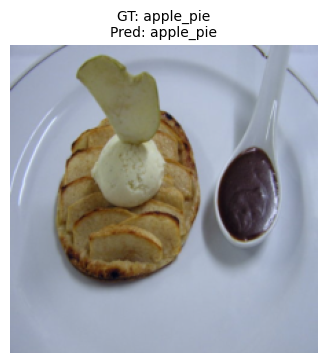

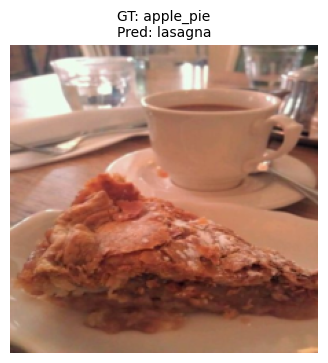

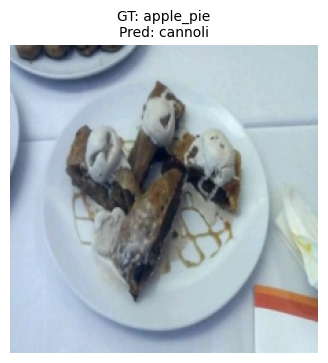

In [18]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# reverse label map
id_to_label = {v:k for k,v in label_to_id.items()}

model.eval()

def visualize_predictions(loader, num_images=3):
    shown = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        probs = F.softmax(outputs, dim=1)
        top5_prob, top5_idx = probs.topk(5, dim=1)

        for i in range(imgs.size(0)):
            if shown >= num_images:
                return

            img = imgs[i].cpu().permute(1,2,0).numpy()
            img = (img - img.min()) / (img.max() - img.min())

            gt = id_to_label[labels[i].item()]
            pred = id_to_label[top5_idx[i][0].item()]

            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.axis("off")

            title = f"GT: {gt}\nPred: {pred}"
            plt.title(title, fontsize=10)

            plt.show()
            shown += 1

# call on test loader
visualize_predictions(test_loader, num_images=3)
